# AX=YB
This notebook shows the process of calibrating the extrinsic parameters between the Vicon marker coordinate frame installed on an object with respect to the object CAD coordinate frame. We use the ICG 3D tracker algorithm to track the 3D pose of the object through its pointcloud observation and the ROS2 vicon bridge to get the pose of the markers installed on it.

## Instantiate the Interfaces
### ROS2

In [1]:
from SimpleHandEye.interfaces.ros2 import ROS2ExecutorManager, ROS2CameraReader, ROS2TFInterface
import rclpy
camera_name = 'back_down_cam'
rclpy.init()    
executor_manager = ROS2ExecutorManager()
camera_reader = ROS2CameraReader(f'/B1/{camera_name}/infra1/image_rect_raw', camera_info_topic=f'/B1/{camera_name}/infra1/camera_info', node_name='camera_reader')
vicon_sensor = ROS2TFInterface('vicon/B1_BODY/B1_BODY', 'vicon/CALIB_BOARD/CALIB_BOARD', node_name='vicon_sensor_node')
executor_manager.add_node(camera_reader)
executor_manager.add_node(vicon_sensor)
executor_manager.start()

In [2]:
vicon_sensor.get_pose()

array([[ 0.44530766, -0.69447583, -0.56515875, -0.21916487],
       [-0.81363296, -0.57734564,  0.0683624 ,  1.30864266],
       [-0.37376797,  0.42938949, -0.82214486, -0.54114016],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

### April-Tag Tracker

In [3]:

int_params = camera_reader.get_intrinsics()
K = int_params['K']
D = int_params['D']
K,D

(array([[380.45697021,   0.        , 319.83480835],
        [  0.        , 380.45697021, 237.94465637],
        [  0.        ,   0.        ,   1.        ]]),
 array([0., 0., 0., 0., 0.]))

In [5]:
from SimpleHandEye.interfaces.apriltag import ApriltagTracker

tag_size = 0.1285
tracker = ApriltagTracker(tag_size=tag_size,
                          intrinsic_matrix=K,
                          distortion_coeffs=(None if D[0] == 0 else D))

tracker.getPose(camera_reader.color_frame, tag_id=0)

array([[ 0.00424248,  0.96031609, -0.27888172,  0.08718904],
       [-0.99442461,  0.03343627,  0.10000857,  0.03649557],
       [ 0.1053646 ,  0.27690256,  0.9551038 ,  0.22292754],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

## Instantiate the Solver

In [6]:
from SimpleHandEye.solvers import OpenCVSolver
solver = OpenCVSolver()

## Collect The Calibration Dataset

In [7]:
import ipywidgets as widgets
import numpy as np
from IPython.display import display
from pprint import pprint
from IPython.display import clear_output
np.set_printoptions(suppress=True, precision=3)

# The dataset
A_list = []
B_list = []
apriltag_info = []
apriltag_imgs_raw = []
apriltag_imgs_udist = []
def on_sample_clicked(b):
    img = camera_reader.color_frame
    info = tracker.getPoseAndCorners(img, tag_id=0)
    if info is None:
        return
    A = vicon_sensor.get_pose()
    B = info['pose']
    apriltag_info.append(info)
    apriltag_imgs_raw.append(img)
    apriltag_imgs_udist.append(tracker.undistortImage(img))
    print("A=")
    pprint(A)
    print("B=")
    pprint(B)
    # if A is not None and B is not None:
    A_list.append(A)
    B_list.append(B)
    print("*************")

def on_compute_clicked(b):
    try:
        X,Y = solver.solve(A_list, B_list)
        clear_output(wait=True)
        print("X=")
        pprint(X)
        print("Y=")
        pprint(Y)
    except:
        print("Bad dataset, please record again")
        A_list.clear()
        B_list.clear()
        

sample_button = widgets.Button(description="Sample")
compute_button = widgets.Button(description="Compute")

sample_button.on_click(on_sample_clicked)
compute_button.on_click(on_compute_clicked)
display(sample_button)
display(compute_button)

X=
array([[-0.476,  0.789,  0.388,  0.012],
       [ 0.562,  0.612, -0.556,  0.073],
       [-0.677, -0.046, -0.735, -0.046],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])
Y=
array([[-0.995,  0.097, -0.018,  0.061],
       [ 0.097,  0.995,  0.009,  0.364],
       [ 0.019,  0.007, -1.   , -0.165],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])


In [8]:
X, Y = solver.solve(A_list, B_list)

In [9]:
for i in range(len(A_list)):
    print((A_list[i]@X@np.linalg.inv(Y@B_list[i]))[:3,-1])

[-0.003 -0.    -0.001]
[ 0.003 -0.003 -0.003]
[ 0.001 -0.    -0.002]
[-0.006  0.001  0.002]
[-0.004 -0.002 -0.001]
[-0.003 -0.002 -0.003]
[ 0.001 -0.001 -0.001]
[ 0.001 -0.    -0.   ]
[0.001 0.003 0.003]
[-0.004  0.002  0.004]
[0.001 0.001 0.001]
[0.002 0.003 0.002]
[-0.    -0.     0.002]
[-0.005  0.001  0.001]
[ 0.    -0.002 -0.002]
[ 0.002 -0.001  0.   ]
[ 0.    -0.     0.001]
[-0.001 -0.001 -0.001]
[-0.    -0.001 -0.001]
[-0.     0.001  0.002]
[ 0.005 -0.001  0.   ]
[-0.002 -0.     0.   ]
[-0.002  0.     0.   ]
[ 0.001 -0.001 -0.002]
[ 0.002  0.    -0.002]
[0.001 0.005 0.004]
[ 0.003 -0.     0.   ]
[-0.014  0.005 -0.001]
[0.002 0.001 0.001]
[-0.     0.001 -0.001]
[0.011 0.001 0.001]
[ 0.001 -0.001 -0.002]
[ 0.002 -0.004 -0.003]
[ 0.005 -0.001 -0.003]
[0.004 0.002 0.001]
[ 0.    -0.002 -0.   ]
[ 0.005  0.001 -0.   ]
[-0.002  0.005  0.004]


In [11]:
import pickle
# camera_name = 'side_left_cam'
dataset_name = f'b1-{camera_name}-dataset.pkl'
with open(dataset_name, 'wb') as f:
    data = {
        'A_list': A_list,
        'B_list': B_list,
        'apriltag_info': apriltag_info,
        'apriltag_imgs_raw': apriltag_imgs_raw,
        'apriltag_imgs_udist': apriltag_imgs_udist,
        'camera_matrix': K, 
        'distortion_coeffs': D,
        'X': X,
        'Y': Y,
        'tag_size': tag_size,
    }
    pickle.dump(data, f)

# Reprojection Error Minimization

In [111]:
import symforce
symforce.set_epsilon_to_symbol()
import symforce.symbolic as sf 
import numpy as np
import pickle 
from symforce.opt.optimizer import Optimizer
from symforce.values import Values
from symforce.opt.factor import Factor
import time
dataset_name = '/home/rstaion/Data-HDD/datasets/calibration/B1/simplehandeye/simplehandeye_dataset/b1-d455-dataset.pkl'

with open(dataset_name, 'rb') as f:
    data = pickle.load(f)

pix_ps = np.vstack([info['corners'][np.newaxis,...] for info in data['apriltag_info']]).tolist()

In [112]:
tag_size = data['tag_size']
tag_ps = np.vstack(len(data['A_list'])*[[np.array([[-tag_size/2, tag_size/2, 0],
                                [ tag_size/2, tag_size/2, 0],
                                [ tag_size/2, -tag_size/2, 0],
                                [-tag_size/2,  -tag_size/2, 0]])]]).tolist()

In [113]:
A = [T for T in data['A_list']]
B = [T for T in data['B_list']]
Y = data['Y']
X = data['X']

In [114]:
from SimpleHandEye.optimizers import AXYBReprojectionOptimizer
solver = AXYBReprojectionOptimizer(camera_T_tag='B', camera_matrix=data['camera_matrix']) 

In [115]:
result = solver.solve(A=A, B=B, X=X, Y=Y, pix_ps=pix_ps, tag_ps=tag_ps)

[2024-01-15 21:29:04.976] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+03, error prev/linear/new: 0.627/0.000/0.273, rel reduction: 0.56421
[2024-01-15 21:29:05.007] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e+02, error prev/linear/new: 0.273/0.000/0.297, rel reduction: -0.08465
[2024-01-15 21:29:05.037] [info] LM<sym::Optimize> [iter    2] lambda: 4.000e+02, error prev/linear/new: 0.273/0.000/0.278, rel reduction: -0.01817
[2024-01-15 21:29:05.067] [info] LM<sym::Optimize> [iter    3] lambda: 1.600e+03, error prev/linear/new: 0.273/0.000/0.251, rel reduction: 0.08114
[2024-01-15 21:29:05.098] [info] LM<sym::Optimize> [iter    4] lambda: 1.600e+02, error prev/linear/new: 0.251/0.000/0.286, rel reduction: -0.13968
[2024-01-15 21:29:05.128] [info] LM<sym::Optimize> [iter    5] lambda: 6.400e+02, error prev/linear/new: 0.251/0.000/0.264, rel reduction: -0.05042
[2024-01-15 21:29:05.159] [info] LM<sym::Optimize> [iter    6] lambda: 2.560e+03, error prev/linear/new: 0.251/0.0

In [116]:
solver.getOptimizedResults()

{'X': array([[-0.4794529 ,  0.78555201,  0.39119428,  0.01263117],
        [ 0.55932311,  0.61703858, -0.55355311,  0.07301   ],
        [-0.67622672, -0.04659864, -0.73521832, -0.04725299],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 'Y': array([[-9.93294767e-01, -1.14882321e-02, -1.15037063e-01,
         -4.92422753e-02],
        [ 1.15031276e-01,  1.16539955e-03, -9.93361187e-01,
         -3.78861933e-01],
        [ 1.15460280e-02, -9.99933329e-01,  1.63920721e-04,
          1.37290106e-01],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          1.00000000e+00]])}

## Visualize Errors Before Optimization

In [117]:
import numpy as np
import matplotlib.pyplot as plt

with open(dataset_name, 'rb') as f:
    data = pickle.load(f)


imgs = data['apriltag_imgs_udist']
corners = [info['corners'] for info in data['apriltag_info']]
A = data['A_list']
B = data['B_list']
X = data['X']
Y = data['Y']
K = data['camera_matrix']

tag_size = data['tag_size']
tag_corners = np.array([[-tag_size/2, tag_size/2, 0],
                        [ tag_size/2, tag_size/2, 0],
                        [ tag_size/2, -tag_size/2, 0],
                        [-tag_size/2,  -tag_size/2, 0]])
tag_corners = np.hstack([tag_corners, np.ones((4,1))]).T

In [118]:
for i in range(len(imgs)):
    print((A[i]@X@np.linalg.inv(Y@B[i]))[:3,-1])

[-0.00373568 -0.00181972  0.00876669]
[ 0.00960138 -0.00227069 -0.00028966]
[ 0.00777308 -0.00228924 -0.0070117 ]
[ 0.00675288  0.00022063 -0.00187184]
[-0.00213684 -0.00046986 -0.01688583]
[-0.00287556  0.00026446 -0.01739553]
[-0.00727502  0.00079288 -0.01285859]
[-0.00076163 -0.00178748 -0.00217187]
[ 0.01288345 -0.00946796 -0.00669362]
[ 0.00404842 -0.00358663  0.0008455 ]
[-0.00832745  0.00469039  0.0034428 ]
[-0.01362057  0.00575507  0.00497101]
[-0.00161895  0.0010508  -0.00460644]
[ 0.00880053 -0.00052937 -0.00387751]
[ 0.00934869 -0.00263803 -0.00268503]
[-0.00638421 -0.00699065  0.00218677]
[-0.00931223 -0.00711965  0.00115112]
[ 0.00486586 -0.00530382 -0.00382708]
[ 0.00859162 -0.00128877 -0.00086137]
[0.00240328 0.00371495 0.00690661]
[-0.00807408  0.00524965  0.00639681]
[-0.01195471  0.00517411  0.00298782]
[ 0.00371692 -0.00173549  0.00115573]
[ 0.0057598  -0.00150325  0.00100265]
[-0.00964519  0.00520363  0.00953847]
[-0.00662476  0.00822995  0.01658269]
[0.00157947 0.0

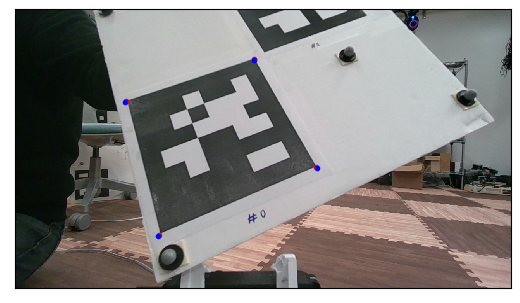

In [119]:
errors = []
for n in range(len(corners)):
# for n in [5]:
    pixel_pos = corners[n].T
    cam_T_tag_est = np.linalg.inv(Y)@A[n]@X
    # cam_T_tag_est = B[n]

    cam_p = cam_T_tag_est@tag_corners
    pixel_pos_hat = K@cam_p[0:3,:]
    pixel_pos_hat = (pixel_pos_hat/pixel_pos_hat[2,:])[0:2,:]
    e = (pixel_pos-pixel_pos_hat).mean(axis=1)
    errors.append(e)
errors = np.array(errors)
plt.imshow(imgs[n])
plt.plot(pixel_pos[0,:], pixel_pos[1,:], 'r.')
plt.plot(pixel_pos_hat[0,:], pixel_pos_hat[1,:], 'b.')
# disable ticks
plt.xticks([])
plt.yticks([])
# plt.savefig(f'results/{dataset_name}_reprojection_before_opt.png', bbox_inches='tight', pad_inches=0)
plt.show()

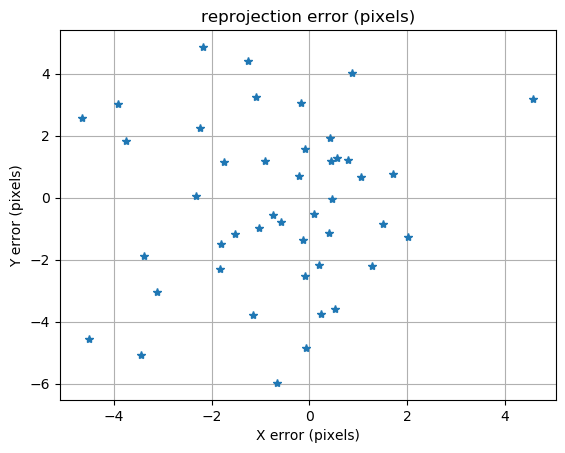

In [120]:
plt.plot(errors[:,0],errors[:,1], '*')
plt.title('reprojection error (pixels)')
plt.xlabel('X error (pixels)')
plt.ylabel('Y error (pixels)')
plt.grid(True)
# disable ticks
# plt.savefig(f'results/{dataset_name}_reprojection_error_before_opt.png', bbox_inches='tight', pad_inches=0)
plt.show()

## Visualization After Optimization

In [121]:
result = solver.getOptimizedResults()
X = result['X']
Y = result['Y']

In [122]:
optimized_B = solver.result.optimized_values['B']
B_opt = []
for b in optimized_B:
    rot = b.rotation().to_rotation_matrix()
    trans = b.t
    T = np.hstack([rot, trans.reshape(3,1)])
    T = np.vstack([T, np.array([0,0,0,1])])
    B_opt.append(T)

In [123]:
import numpy as np
import matplotlib.pyplot as plt

imgs = data['apriltag_imgs_udist']
corners = [info['corners'] for info in data['apriltag_info']]
vicon_T_marker = data['A_list']
camera_T_tag = B_opt
marker_T_tag = result['X']
vicon_T_cam = result['Y']
K = data['camera_matrix']
cam_T_vicon = np.linalg.inv(vicon_T_cam)

tag_size = data['tag_size']
tag_corners = np.array([[-tag_size/2, tag_size/2, 0],
                        [ tag_size/2, tag_size/2, 0],
                        [ tag_size/2, -tag_size/2, 0],
                        [-tag_size/2,  -tag_size/2, 0]])
tag_corners = np.hstack([tag_corners, np.ones((4,1))]).T

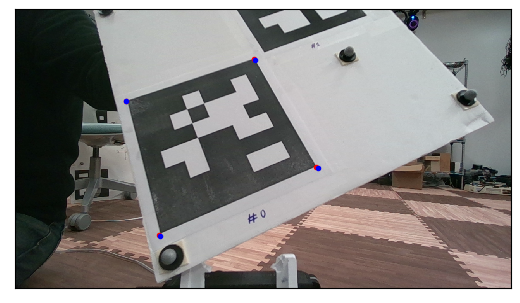

In [124]:
errors = []
for n in range(len(corners)):
    pixel_pos = corners[n].T
    cam_p = cam_T_vicon@vicon_T_marker[n]@marker_T_tag@tag_corners
    pixel_pos_hat = K@cam_p[0:3,:]
    pixel_pos_hat = (pixel_pos_hat/pixel_pos_hat[2,:])[0:2,:]
    e = (pixel_pos-pixel_pos_hat).mean(axis=1)
    errors.append(e)
errors = np.array(errors)
plt.imshow(imgs[n])
plt.plot(pixel_pos[0,:], pixel_pos[1,:], 'r.')
plt.plot(pixel_pos_hat[0,:], pixel_pos_hat[1,:], 'b.')
# disable ticks
plt.xticks([])
plt.yticks([])
# plt.savefig(f'results/{dataset_name}_reprojection_after_opt.png', bbox_inches='tight', pad_inches=0)
plt.show()

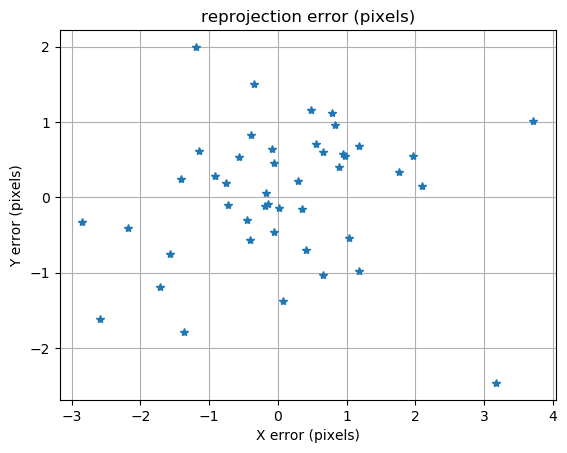

In [125]:
plt.plot(errors[:,0],errors[:,1], '*')
plt.title('reprojection error (pixels)')
plt.xlabel('X error (pixels)')
plt.ylabel('Y error (pixels)')
plt.grid(True)
# plt.savefig(f'results/{dataset_name}_reprojection_error_after_opt.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [126]:
for i in range(len(imgs)):
    print((A[i]@X@np.linalg.inv(Y@B_opt[i]))[:3,-1])

[-0.00492831 -0.00146026  0.01031957]
[ 0.00850225 -0.00181251  0.00199868]
[ 0.00688321 -0.00196606 -0.0053807 ]
[5.91357673e-03 3.81696538e-04 7.64494313e-05]
[-0.00434804 -0.00101884 -0.01646726]
[-0.00514257 -0.00025559 -0.01599062]
[-0.01003848  0.0002044  -0.01142232]
[-0.00340925 -0.00236193  0.00048609]
[ 0.00963553 -0.00986022 -0.00334454]
[ 0.00170848 -0.00423144  0.00362504]
[-0.01044291  0.0039386   0.00511393]
[-0.01553149  0.00497161  0.00564347]
[-0.00326832  0.00037159 -0.00480648]
[ 0.00705943 -0.0011871  -0.00470999]
[ 0.00781925 -0.00326133 -0.00434196]
[-0.00780479 -0.00754938 -0.00024723]
[-0.00982931 -0.00782209 -0.00146875]
[ 0.00491043 -0.00523863 -0.00393152]
[ 0.00814898 -0.00154097 -0.00070644]
[0.00149272 0.00319559 0.00752372]
[-0.00946604  0.00456903  0.00746138]
[-0.01309932  0.00430086  0.00464556]
[ 0.00207065 -0.00248758  0.00372039]
[ 0.00478712 -0.00239332  0.00340427]
[-0.01019191  0.00421536  0.01071406]
[-0.00720191  0.00717398  0.0165942 ]
[ 0.00

In [127]:
body_T_cam = Y
camera_frame_name = 'b1_d455_cam_color_optical_frame'

In [128]:
result = {camera_frame_name:body_T_cam.copy().tolist(),
          'parent_frame':'vicon/B1_BODY/B1_BODY'}

In [129]:
import yaml
with open(f'{camera_frame_name}.yaml', 'w') as f:
    yaml.dump(result, f)